Let's train a very simple non-linear multivariate regression model using PyTorch.

In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

Create a simple PyTorch Module. This Module models the function:

$y = M_2 (M_1 x + b_1) + b_2$

And you want to minimize:

$L = || y - y_{observed} ||^2 + \lambda_1 ||M_1||_F + + \lambda_2 ||M_2||_F$

where $x$ and $y$ are vectors and we're taking the Frobenius norm of our parameters. 

Note that $M_1$ and $M_2$ aren't necessarily square. In fact, if we set the shapes of $M_1$ and $M_2$ to be small we can try to "squeeze" into a smaller space and effectively build-in dimensionality reduction.

This whole model is slightly more complicated than vanilla linear regression, and is now something like quadratic (because of the two matrix multiplies) vector regression (because we're predicting a vector outcome, not a scalar one).

We can split the above model into three steps, which (1) initialize parameters, (2) compute a prediction, and (3) compute the loss.

- Declare that you'll be optimizing two linear functions. This saves space for $M_1$, $M_2$, $b_1$ and $b_2$, but not $x$ or $y$. Putting it in the `__init__` function of a `nn.Module` is special: PyTorch will remember that these parameters are optimize-able.
- `forward` tells us how to combine our parameters to make a prediction $y$
- `loss` tells us how to compare our prediction vector to our observed vector, plus how to minimize our regularizer.

In [13]:
class Bottleneck(nn.Module):
    def __init__(self, n_in_cols, n_out_cols, n_hidden=3):
        super(Bottleneck, self).__init__()
        self.lin1 = nn.Linear(n_in_cols, n_hidden)
        self.lin2 = nn.Linear(n_hidden, n_out_cols)
    
    def forward(self, x):
        # x is a minibatch of rows of our features
        hidden = self.lin1(x)
        # y is a minibatch of our predictions
        y = self.lin2(hidden)
        return y

    def loss(self, prediction, target, lam1=1e-3, lam2=1e-3):
        # This is just the mean squared error
        loss_likelihood = ((prediction - target)**2.0).sum()
        # This computes our Frobenius norm over both matrices
        # Note that we can access the Linear model's variables
        # directly if we'd like. No tricks here!
        loss_prior_m1 = (self.lin1.weight**2.0 * lam1).sum()
        loss_prior_m2 = (self.lin2.weight**2.0 * lam2).sum()
        loss = loss_likelihood + loss_prior_m1 + loss_prior_m2
        return loss

Let's make up some fake data to fit. Annoyingly, it has to be `float32` or `int64`.

In [60]:
X = np.random.normal(size=(2000, 9)).astype(np.float32)
Y = np.random.normal(size=(2000, 4)) + np.dot(X, np.random.normal(size=(9, 4)))
Y = Y.astype(np.float32)

In [61]:
X.shape, Y.shape

((2000, 9), (2000, 4))

Initialize the model. Note that we'll also initialize the "optimizer". Check out [this link](http://ruder.io/optimizing-gradient-descent/) to learn more about different optimizers. For now, `Adam` is a good choice.

In [62]:
model = Bottleneck(9, 4, 3)
o = optim.Adam(model.parameters())

In [63]:
def chunks(array, size):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(array), size):
        yield array[i:i + size]

In [79]:
batch_size = 100

losses = []
for epoch in range(100):
    for feature, target in zip(chunks(X, batch_size), chunks(Y, batch_size)):
        # This zeros the gradients on every parameter. 
        # This is easy to miss and hard to troubleshoot.
        o.zero_grad()
        # Convert 
        feature = Variable(torch.from_numpy(feature))
        target = Variable(torch.from_numpy(target))
        # Compute a prediction for these features
        prediction = model.forward(feature)
        # Compute a loss given what the true target outcome was
        loss = model.loss(prediction, target)
        break
        # Backpropagate: compute the direction / gradient every model parameter
        # defined in your __init__ should move in in order to minimize this loss
        # However, we're not actually changing these parameters, we're just storing
        # how they should change.
        loss.backward()
        # Now take a step & update the model parameters. The optimizer uses the gradient at 
        # defined on every parameter in our model and nudges it in that direction.
        o.step()
        print(epoch, loss.data)
        # Record the loss per example
        losses.append(loss.data.numpy() / len(feature))

I can introspect my model and get the parameters out:

In [81]:
model.lin1.weight.data.numpy()

array([[ 0.5259787 ,  0.7521889 ,  0.3132558 , -0.518142  ,  0.12818258,
        -0.2503705 ,  0.37496164, -0.27387676, -0.33467487],
       [-0.06808124,  0.44446138, -0.64465845,  0.5860432 , -0.4473237 ,
         0.00145725,  0.25221378,  0.18153091,  0.53698903],
       [-0.29297045,  0.6610544 , -0.19084436, -0.0291331 ,  0.11641134,
         0.759331  ,  0.67115396, -0.56799036, -0.20327038]],
      dtype=float32)

In [84]:
model.lin1.bias.data.numpy()

array([ 0.25160268, -0.03068716,  0.23243836], dtype=float32)

I can also see that the loss is simply a scalar:

In [82]:
loss

tensor(1373.7545, grad_fn=<ThAddBackward>)

You can see that the gradient is zero before we call `loss.backward()`

In [86]:
model.lin1.bias.grad

tensor([0., 0., 0.])

...And non-zero afterwards.

In [89]:
model.lin1.bias.grad

tensor([0., 0., 0.])

And after we run `o.step()` we'll notice that the bias parameter has been updated:

In [88]:
model.lin1.bias.data.numpy()

array([ 0.25160268, -0.03068716,  0.23243836], dtype=float32)

Let's check on convergence:

In [56]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

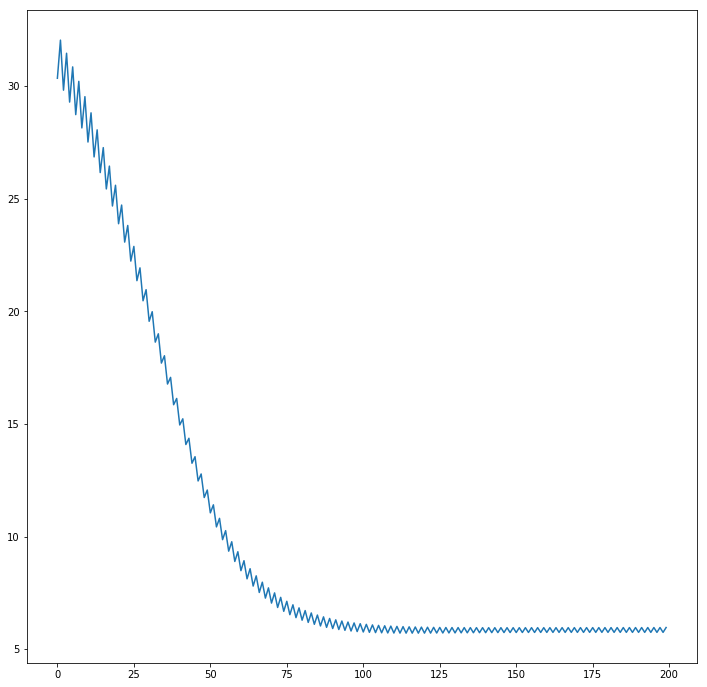

In [57]:
n = len(losses)
smooth = np.convolve(losses, np.ones((n,))/n, mode='valid')
plt.figure(figsize=(12, 12))
plt.plot(losses[::10])
plt.plot(smooth, c='r')

Looks converged to me!

You can always introspect the model:

In [59]:
model.lin1.weight.data.numpy()

array([[ 0.7794705 , -0.43732855, -1.0287371 , -0.11247949,  0.568342  ,
         0.49956107,  0.19608836,  0.5779622 ,  0.06629488],
       [-0.37802327, -0.17743906,  1.3143018 ,  0.01701887, -0.90420395,
         1.060398  ,  0.75470215, -0.4543838 , -0.08977735],
       [-0.2767018 ,  0.45004418, -0.7878338 , -0.25858688, -1.1907098 ,
         0.35363907, -0.16729821, -0.11728066,  0.41289246]],
      dtype=float32)